# Executive Order Embeddings

In [ ]:
%run notebooks/Setup.ipynb

import pandas
import numpy
from numpy import ndarray
import json
import os
import pandas
import queue
import time
from itertools import product
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

from sentence_transformers import SentenceTransformer
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_ollama import OllamaEmbeddings
from sklearn.cluster import KMeans, HDBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [2]:
eo_dir = 'data/executive_orders/raw/'
eo_paths = os.listdir(eo_dir)

def batched(list_in, batch_size):
    return [list_in[i * batch_size:(i + 1) * batch_size] for i in range((len(list_in) + batch_size - 1) // batch_size )]

## SFR-Embedding-2

One of the top models for clustering on https://huggingface.co/spaces/mteb/leaderboard

In [ ]:
# gpu
num_gpus = 1
models = [
    [i, SentenceTransformer("Salesforce/SFR-Embedding-2_R", device=f'cuda:{i}')] for i in range(num_gpus)
]

In [ ]:
# create batches of EOs to embed
eo_paths_batches = batched(eo_paths, 10)

In [ ]:
def embed_batch(batch_i, batch, model):
    eos = []
    for path in batch:
        with open(eo_dir + path, 'r') as f:
            eo_doc = json.load(f)
        eos.append('\n'.join(eo_doc['content']))

    embeddings = model.encode(list(map(lambda x: str(x), eos)))

    df = pandas.DataFrame(embeddings)
    df.insert(0, 'file', batch)
    df.to_csv(f'data/executive_orders/embeddings/batch_{batch_i}.csv')

In [ ]:
# perform the emdeddings
model_pool = queue.Queue()
for model in models:
    model_pool.put(model)

def process_batch(i, batch):
    # block until a model becomes available
    model = model_pool.get()
    try:
        embed_batch(i, batch, model[1])
        print(f"Embedded batch {i} with model {model[0]}")
    finally:
        model_pool.put(model)

with ThreadPoolExecutor(max_workers=len(models)) as executor:
    for i, batch in enumerate(eo_paths_batches):
        executor.submit(process_batch, i, batch)

## Nomic/Gemini

In [3]:
def build_embeddings(
    embedding_model,
    target_dir,
    batch_size,
    max_workers=1,
    first_n=None,
    sleep_between_batches=None
):
    def embed_eo(eo_batch):
        # load all the documents in the batch
        results = []
        documents = []
        for eo_path in eo_batch:
             results.append({ 'path': eo_path })
             with open(eo_dir + eo_path) as source_file:
                eo = json.load(source_file)
                documents.append('\n'.join(eo["content"]))

        # embed the documents
        start_time = time.time()
        try:
            embeddings = embedding_model.embed_documents(documents)
            
            duration = (time.time() - start_time) / len(eo_batch)
            for eo_i, result in enumerate(results):
                result['duration'] = duration
                result['embedding'] = embeddings[eo_i]

                with open(target_dir + result['path'], 'w') as target_file:
                    json.dump(result | { 'embedding':  embeddings[eo_i] }, target_file)
        except Exception as e:
            print(f"Error embedding batch: {str(e)}")

        if sleep_between_batches is not None:
            time.sleep(sleep_between_batches)

        return results
    
    # chunk eo_paths into batches
    eo_paths_batches = batched(eo_paths if first_n is None else eo_paths[:first_n], batch_size)

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(embed_eo, eo_batch) for eo_batch in eo_paths_batches]
        
        for future in as_completed(futures):
            results.extend(future.result())

    pandas.DataFrame(results)

In [ ]:
build_embeddings(
    OllamaEmbeddings(
        model="nomic-embed-text",
        num_ctx=8096
    ),
    'data/executive_orders/embeddings/nomic/',
    10
)

In [ ]:
build_embeddings(
    GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"),
    'data/executive_orders/embeddings/gemini/',
    100,
    sleep_between_batches=10
)

## Clustering

In [3]:
def load_sfr_embeddings(embeddings_dir):
    embeddings_paths = os.listdir(embeddings_dir)

    def load_csv(file_name):
        return pandas.read_csv(embeddings_dir + file_name, index_col=0)

    with ThreadPoolExecutor() as executor:
        embeddings_dfs = list(executor.map(load_csv, embeddings_paths))

    embeddings_df = pandas.concat(embeddings_dfs, ignore_index=True)

    # combine the individual embedding values into a single column
    embedding_columns = [str(i) for i in range(4096)]
    embeddings_df['embedding'] = embeddings_df[embedding_columns].values.tolist()
    embeddings_df.drop(columns=embedding_columns, inplace=True)

    return embeddings_df

def load_embeddings(embeddings_dir):
    embeddings_paths = os.listdir(embeddings_dir)

    def load_json(file_name):
        with open(embeddings_dir + file_name) as f:
            json_file = json.load(f)
            return json_file if 'embedding' in json_file else None
        
    embeddings = [] 
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_json, path) for path in embeddings_paths]

        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                embeddings.append(result)

    return pandas.DataFrame(embeddings)

### K Means

In [ ]:
def cluster_kmeans(embeddings: ndarray, k: int):
    # fit the clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(embeddings)

    # return the clusters and error
    return clusters, kmeans.inertia_, metrics.silhouette_score(embeddings, clusters)

def search_k(embeddings: ndarray, max_k: int) -> None:
    k_values = range(2, max_k + 1)
    errors = []
    silhouette_scores = []
    
    # Calculate metrics for each k
    for k in k_values:
        _, error, sil_score = cluster_kmeans(embeddings, k)
        errors.append(error)
        silhouette_scores.append(sil_score)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot the elbow curve
    ax1.plot(k_values, errors, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    ax1.grid(True)
    
    # Plot the silhouette scores
    ax2.plot(k_values, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def apply_pca(df: pandas.DataFrame):
    pca_df = df.copy()

    pca = PCA(n_components=2)
    pca_df[['pca1', 'pca2']] = pca.fit_transform(numpy.array(pca_df['embedding'].tolist()))

    # Create a scatter plot of the PCA results, colored by cluster
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_df['pca1'], pca_df['pca2'], c=pca_df['cluster'], cmap='viridis', s=5)
    plt.colorbar(label='Cluster')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    return pca_df

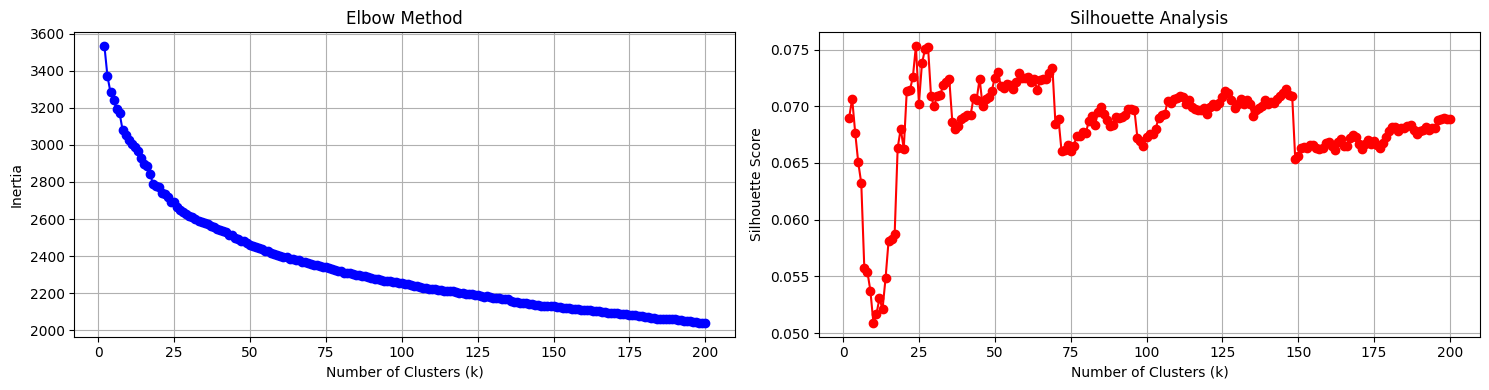

In [ ]:
# cluster using gemini embeddings
search_k(
    numpy.array(load_embeddings('data/executive_orders/embeddings/gemini/')["embedding"].tolist()),
    200
)

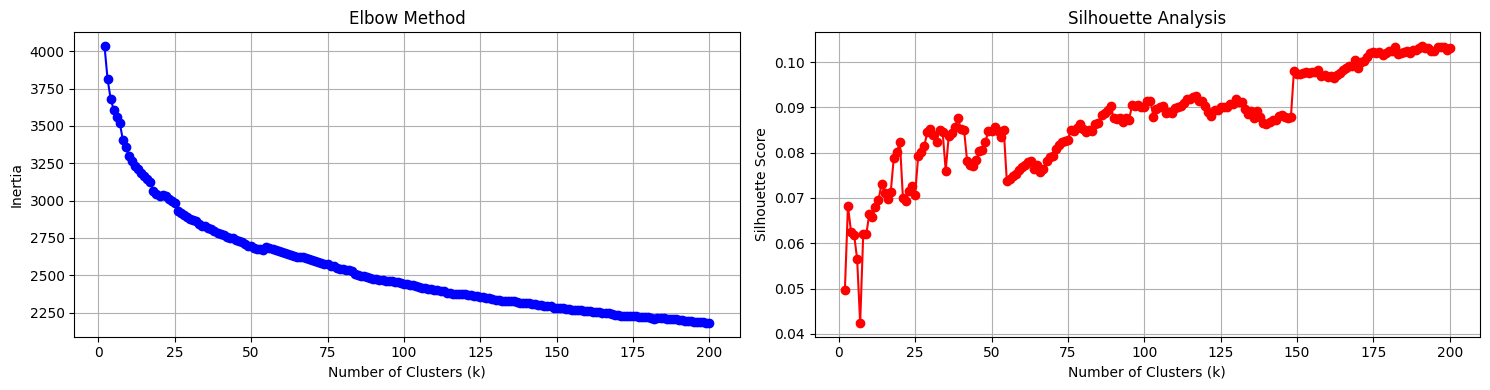

In [ ]:
# cluster using nomic embeddings
search_k(
    numpy.array(load_embeddings('data/executive_orders/embeddings/nomic/')["embedding"].tolist()),
    200
)

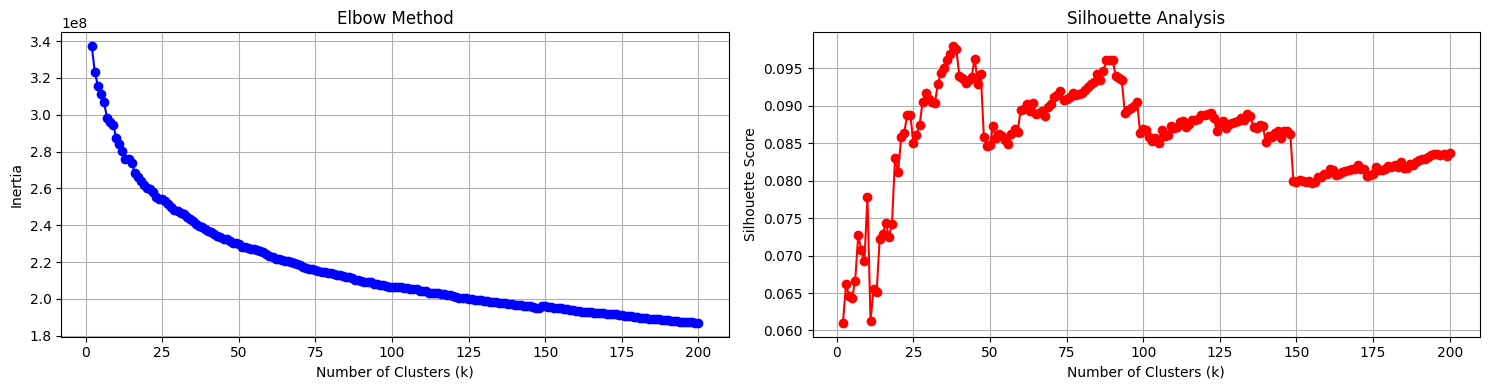

In [ ]:
# cluster using sfr embeddings
search_k(
    numpy.array(load_sfr_embeddings('data/executive_orders/embeddings/sfr-embedding-2/')["embedding"].tolist()),
    200
)

### HDBSCAN

In [ ]:
def process_hdbscan(params, embeddings):
    method, cluster_size, alpha, epsilon, embeddings = params
    
    hdb = HDBSCAN(
        n_jobs=-1,
        min_cluster_size=cluster_size,
        cluster_selection_method=method,
        alpha=alpha,
        cluster_selection_epsilon=epsilon
    )
    hdb.fit(embeddings)

    mask = hdb.labels_ != -1
    if len(numpy.unique(hdb.labels_[mask])) > 1 and numpy.sum(mask) > 1:
        silhouette = metrics.silhouette_score(embeddings[mask], hdb.labels_[mask])
    else:
        silhouette = -1  # Invalid configuration - not enough clusters or samples
    
    results = {
        'method': method,
        'cluster_size': cluster_size,
        'alpha': alpha,
        'epsilon': epsilon,
        'n_outliers': len(hdb.labels_[hdb.labels_ == -1]),
        'n_clusters': len(numpy.unique(hdb.labels_)),
        'silhouette': silhouette
    }
    return results

# do a grid search for hdbscan
def hdbscan_grid(embeddings):
    # Create parameter combinations
    methods = ['leaf', 'eom']
    cluster_sizes = range(2, 8, 2)
    alphas = numpy.arange(0.01, 1.6, 0.2)
    epsilons = numpy.arange(0.01, 2, 0.2)

    # Create all combinations of parameters
    param_combinations = [
        (method, cs, alpha, epsilon, embeddings)
        for method, cs, alpha, epsilon in product(methods, cluster_sizes, alphas, epsilons)
    ]

    # Create a process pool and run the calculations
    results = []
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(process_hdbscan, params) for params in param_combinations]

        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            print(json.dumps(result, indent=4))

    return results

In [ ]:
hdbscan_grid(load_embeddings('data/executive_orders/embeddings/nomic/')["embedding"].tolist())

In [18]:
# load the nomic results from hdbscan_nomic.txt
hdbscan_grid_results = []
with open('data/executive_orders/hdbscan_nomic.txt', 'r') as f:
    # every 9 lines is a new result as json, read 9 at a time until were out of rows
    while True:
        lines = [f.readline() for _ in range(9)]
        if not lines[0]:
            break
        hdbscan_grid_results.append(json.loads(''.join(lines)))

# convert the results to a dataframe
hdbscan_grid_df = pandas.DataFrame(hdbscan_grid_results)

In [ ]:
# we want to minimize the number of outliers and have clusters that are not too unique
# look for parameters where we have less than 500 outliers, 50-500 clusters, and sort by silhouette\
hdbscan_grid_df[
    (hdbscan_grid_df['n_outliers'] <= 500) &
    (hdbscan_grid_df['n_clusters'] >= 50) &
    (hdbscan_grid_df['n_clusters'] <= 500)
].sort_values('silhouette', ascending=False).head(10)


### Visualization

In [ ]:
nomic_df = load_embeddings('data/executive_orders/embeddings/nomic/')
cluster_kmeans(numpy.array(nomic_df["embedding"].tolist()), 100)

In [ ]:
def apply_tsne(df, n_components=2, perplexity=30, max_iter=1000):
    embeddings = numpy.array(df["embedding"].tolist())

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        max_iter=max_iter,
        random_state=42
    )
    
    transformed = tsne.fit_transform(embeddings)
    result_df = df.copy()
    
    # Add t-SNE components as new columns
    for i in range(n_components):
        result_df[f'tsne_{i+1}'] = transformed[:, i]

    plt.figure(figsize=(14, 14))
    
    if 'cluster' in result_df.columns:
        scatter = plt.scatter(
            result_df['tsne_1'],
            result_df['tsne_2'],
            c=result_df['cluster'],
            cmap='tab20',
            alpha=0.6
        )
        plt.colorbar(scatter, label='Cluster')
    else:
        plt.scatter(
            result_df['tsne_1'],
            result_df['tsne_2'],
            alpha=0.6
        )
        
    plt.title('t-SNE Visualization of Document Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()

    return result_df

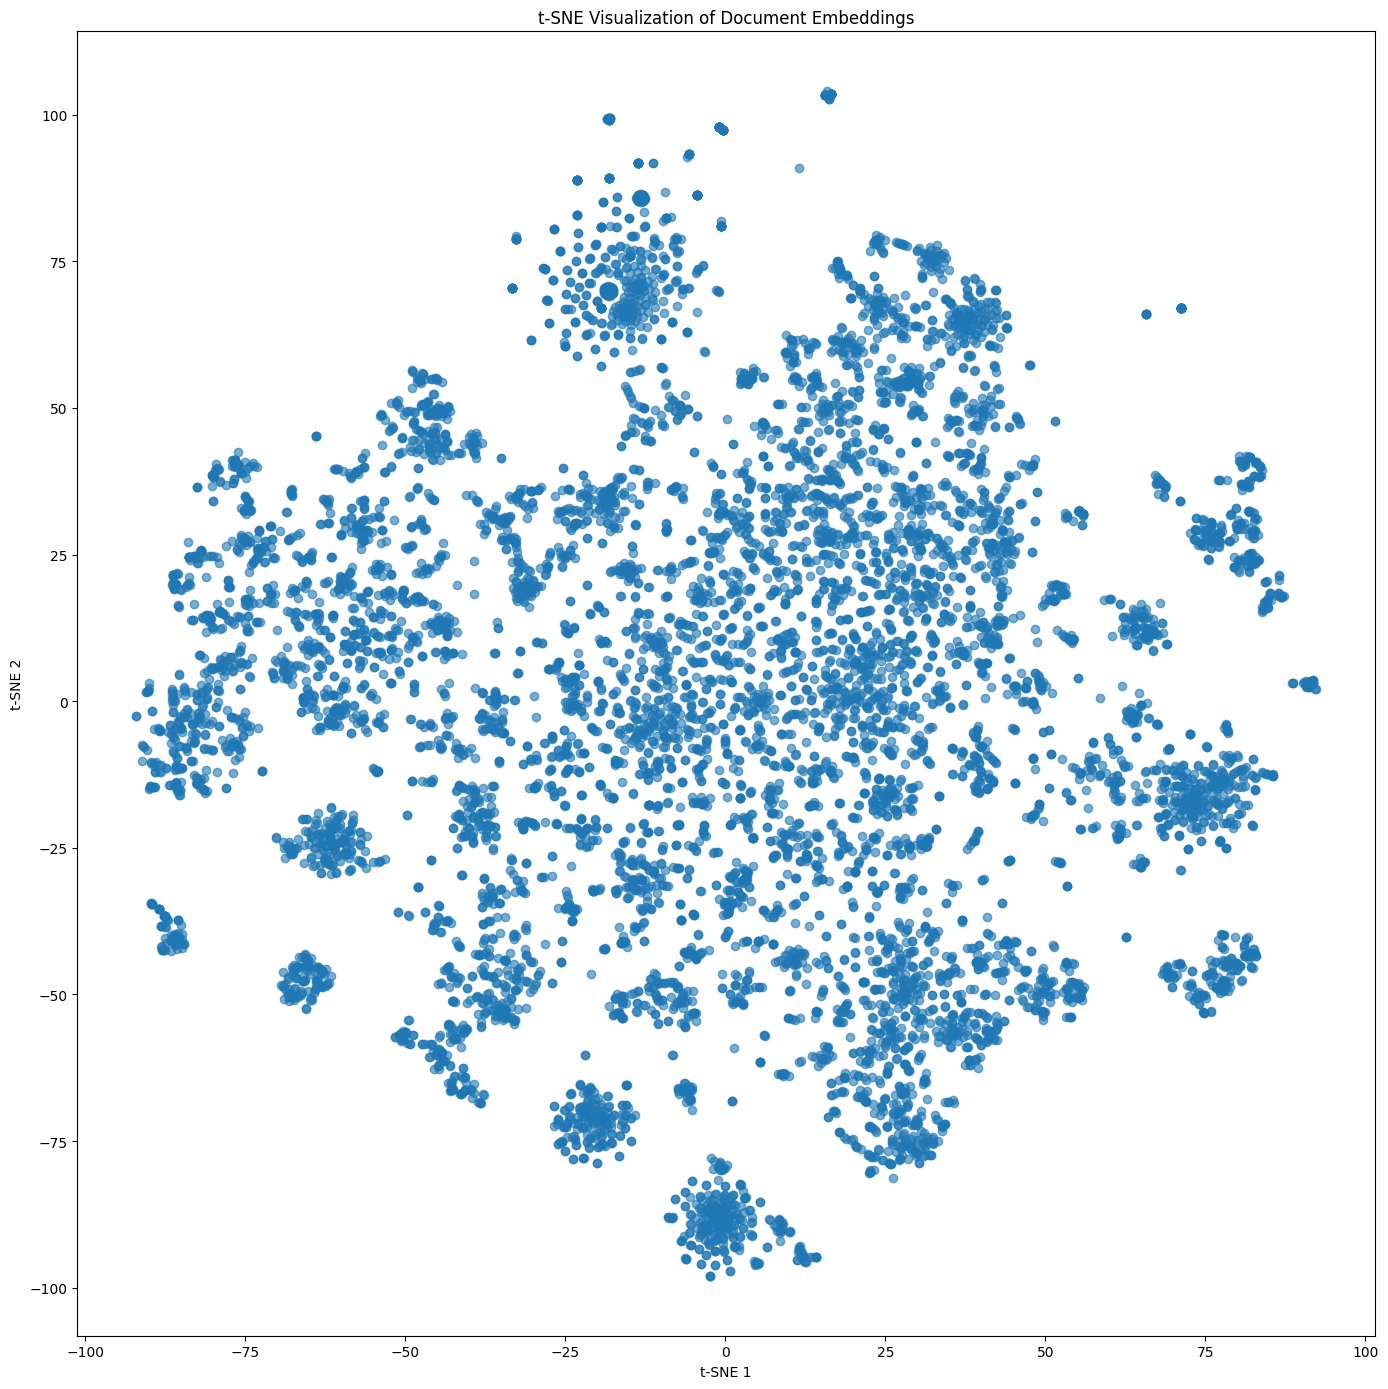

In [92]:
result = apply_tsne(nomic_df, perplexity=30)